In [1]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense
from keras.models import Sequential
from sklearn.metrics import classification_report, multilabel_confusion_matrix, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
from keras.utils import to_categorical

Using TensorFlow backend.


In [2]:
# creates a model that categorizes images as 'swimming', 'skiing' or 'biking'
# images for training and validation were generated from a single image in each category
# overall accuracy 0.9957 with loss of .03
# model correctly predicts tests images in each category

In [3]:
# GET THE DATA
batch_size = 30

train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
validation_datagen = ImageDataGenerator(rescale=1./255)

# read training images, resize all images to 300x300
train_generator = train_datagen.flow_from_directory('data/images/train', target_size=(300, 300), batch_size=batch_size, 
    class_mode='categorical', shuffle=True)

print(train_generator.class_indices)
print(train_generator.samples)

# read validation images, resize all images to 300x300
validation_generator = validation_datagen.flow_from_directory('data/images/validate', target_size=(300, 300), batch_size=batch_size,
    class_mode='categorical', shuffle=True)

print(validation_generator.class_indices)
print(validation_generator.samples)

Found 233 images belonging to 3 classes.
{'bike': 0, 'ski': 1, 'swim': 2}
233
Found 73 images belonging to 3 classes.
{'bike': 0, 'ski': 1, 'swim': 2}
73


In [4]:
# BUILD CNN MODEL
def CNN(): 

    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3), input_shape=(300, 300, 3))) 
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, (3, 3)))
    
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())  
    model.add(Dense(64))
    
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(3))
    
    model.add(Activation('softmax'))
    
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  #Calculates the mean accuracy rate across all predictions for multiclass classification problems.
                  metrics=['categorical_accuracy'])

    return model

In [5]:
model = CNN()

In [6]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 298, 298, 32)      896       
_________________________________________________________________
activation_1 (Activation)    (None, 298, 298, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 149, 149, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 147, 147, 32)      9248      
_________________________________________________________________
activation_2 (Activation)    (None, 147, 147, 32)      0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 73, 73, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 71, 71, 64)        18496     
__________

In [7]:
from collections import Counter

counter = Counter(train_generator.classes)                          
max_val = float(max(counter.values()))       
class_weights = {class_id : max_val/num_images for class_id, num_images in counter.items()}  
print(class_weights)

{0: 3.2580645161290325, 1: 1.0, 2: 1.0}


In [8]:
# RUN THE MODEL
EPOCHS = 10

train_steps_per_epoch = np.math.ceil(train_generator.samples / train_generator.batch_size)
validation_steps_per_epoch = np.math.ceil(validation_generator.samples / validation_generator.batch_size)

#trains the mocel
history = model.fit_generator( 
    train_generator, 
    use_multiprocessing=True, 
    workers=36, 
    steps_per_epoch=train_steps_per_epoch, 
    epochs=EPOCHS, 
    validation_data=validation_generator, 
    validation_steps=validation_steps_per_epoch,
    class_weight=class_weights)

Epoch 1/10
8/8 [==============================] - 119s 15s/step - loss: 1.9792 - categorical_accuracy: 0.4202 - val_loss: 0.6950 - val_categorical_accuracy: 0.6027
Epoch 2/10
8/8 [==============================] - 118s 15s/step - loss: 0.7767 - categorical_accuracy: 0.8260 - val_loss: 0.4680 - val_categorical_accuracy: 0.8219
Epoch 3/10
8/8 [==============================] - 115s 14s/step - loss: 0.5537 - categorical_accuracy: 0.8230 - val_loss: 0.3574 - val_categorical_accuracy: 0.7945
Epoch 4/10
8/8 [==============================] - 116s 14s/step - loss: 0.4016 - categorical_accuracy: 0.9122 - val_loss: 0.1726 - val_categorical_accuracy: 0.9178
Epoch 5/10
8/8 [==============================] - 120s 15s/step - loss: 0.1658 - categorical_accuracy: 0.9696 - val_loss: 0.0447 - val_categorical_accuracy: 0.9863
Epoch 6/10
8/8 [==============================] - 130s 16s/step - loss: 0.0749 - categorical_accuracy: 0.9833 - val_loss: 8.3906e-04 - val_categorical_accuracy: 1.0000
Epoch 7/10
8

In [9]:
print(max(history.history['categorical_accuracy']))

0.9957081509250428


In [10]:
validation_steps_per_epoch = np.math.ceil(validation_generator.samples / validation_generator.batch_size)
predictions = model.predict_generator(validation_generator, steps=validation_steps_per_epoch)

In [11]:
predicted_classes = np.argmax(predictions, axis=1) 
true_classes = validation_generator.classes
class_labels = list(validation_generator.class_indices.keys())  

In [13]:
# SAVE MODEL
#model.save_weights('models/cnn_image_10_epochs.h5') # save model

In [20]:
print(history.history)
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))
print(max(history.history['categorical_accuracy']))

{'val_loss': [0.6950177191054985, 0.4680371578425577, 0.3573818745678418, 0.17260427221859972, 0.04471206144519048, 0.000839059069682525, 7.628519642198688e-05, 0.26625244299026385, 0.0012605707280733303, 0.0004772717543907164], 'val_categorical_accuracy': [0.602739737458425, 0.8219178188337039, 0.7945205356976758, 0.9178082118295643, 0.986301358431986, 1.0, 1.0, 0.9041095702615503, 1.0, 1.0], 'loss': [1.9918698916619428, 0.7684727738343595, 0.5517196537599032, 0.4068512530285913, 0.16633020811454421, 0.07521848121953753, 0.07909576549862268, 0.05498952680675097, 0.03820310673844309, 0.03322140033114022], 'categorical_accuracy': [0.41630901863134984, 0.8283261815365803, 0.8240343278569725, 0.9098712461700766, 0.969957068754368, 0.982832611374589, 0.9957081509250428, 0.9914163018500856, 0.9828326116304029, 0.9957081509250428]}
0.9957081509250428


<Figure size 432x288 with 0 Axes>

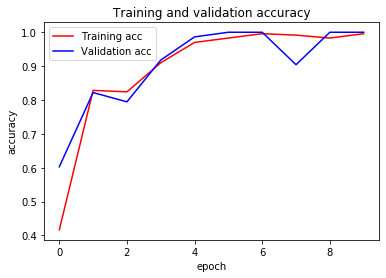

<Figure size 432x288 with 0 Axes>

In [15]:
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.ylabel('accuracy') 
plt.xlabel('epoch')
plt.legend()
plt.figure()

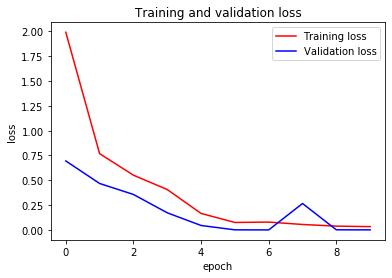

In [16]:
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.ylabel('loss') 
plt.xlabel('epoch')
plt.legend()
plt.show()

In [17]:
img = load_img('data/images/test/swimming1.jpeg', target_size=(300,300)) 
x = img_to_array(img)
x = x.reshape((1,) + x.shape)

prediction = model.predict(x ,batch_size=32, verbose=1)
print(np.argmax(prediction, axis=1))

1/1 [==============================] - 0s 179ms/step
[2]


In [18]:
img = load_img('data/images/test/skiing1.jpeg', target_size=(300,300))
x = img_to_array(img)
x = x.reshape((1,) + x.shape)

prediction = model.predict(x ,batch_size=32, verbose=1)
print(np.argmax(prediction, axis=1))

1/1 [==============================] - 0s 173ms/step
[1]


In [19]:
img = load_img('data/images/test/biking1.jpeg', target_size=(300,300))
x = img_to_array(img)  
x = x.reshape((1,) + x.shape)

prediction = model.predict(x ,batch_size=32, verbose=1)
print(np.argmax(prediction, axis=1))

1/1 [==============================] - 0s 186ms/step
[0]
